In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout

%matplotlib inline

Using TensorFlow backend.


In [15]:
class AE():
    def __init__(self,input_data_path="../4x4matrix.csv", optimizer='rmsprop', loss='mean_squared_error'):
        #self.p_matrix = np.array(pd.read_csv(input_data_path, index_col=0).iloc[:,0:16])
        #self.q_matrix = np.array(pd.read_csv(input_data_path, index_col=0).iloc[:,16:])
        #self.p_matrix = np.array(df.iloc[:,0:16])
        #self.q_matrix = np.array(df.iloc[:,16:])
        self.p_matrix = np.load("4x4matrix.npz")["p_matrix"]
        self.q_matrix = np.load("4x4matrix.npz")["q_matrix"]
        self.optimizer = optimizer
        self.model = Sequential()
        self.model.add( Dense(16, activation = 'relu', input_dim = 9) )
        self.model.add( Dense(16, activation = 'relu') )
        self.model.add( Dense(16, activation = 'hard_sigmoid') )
        #self.model.add( Dropout(0.2) )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        #self.model.add( Dense(16, activation = keras.layers.ReLU(max_value=1, negative_slope=0, threshold = 0)) )
        self.model.compile(optimizer = 'rmsprop',
                           loss='mean_squared_error',
                           metrics = ['accuracy'])
        
    def fit(self, epochs='4', batch_size='256'):
        self.model.fit(self.q_matrix, self.p_matrix,
                      epochs = epochs,
                      batch_size = batch_size,
                      validation_data = (self.q_matrix, self.p_matrix))
    
    def predict(self, test_img):
        self.preds = self.model.predict(test_img).reshape(4,4)
        self.preds_binary = self.preds.copy()
        self.preds_binary[self.preds_binary < 0.5] = 0
        self.preds_binary[self.preds_binary >= 0.5] = 1
        print(self.preds, self.preds_binary)
        self.fig, self.axes = plt.subplots(nrows = 1, ncols = 3, figsize = (14,14))
        self.axes[0].imshow(test_img.reshape(3,3), cmap = plt.cm.binary)
        self.axes[0].set_title("original image")
        self.axes[1].imshow(self.preds, cmap = plt.cm.binary)
        self.axes[1].set_title("predicted image")
        self.axes[2].imshow(self.preds_binary, cmap = plt.cm.binary)
        self.axes[2].set_title("predicted image with binalization")

In [16]:
autoencoder = AE()

In [17]:
autoencoder.model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                160       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_8 (Dense)              (None, 16)                272       
Total params: 704
Trainable params: 704
Non-trainable params: 0
_________________________________________________________________


In [18]:
autoencoder.fit(epochs = 5, batch_size=512)

Train on 983040 samples, validate on 983040 samples
Epoch 1/5
983040/983040 [==============================] - 8s 8us/step - loss: 0.2202 - acc: 0.0755 - val_loss: 0.2163 - val_acc: 0.0624
Epoch 2/5
983040/983040 [==============================] - 8s 8us/step - loss: 0.2163 - acc: 0.0804 - val_loss: 0.2162 - val_acc: 0.0410
Epoch 3/5
983040/983040 [==============================] - 9s 9us/step - loss: 0.2162 - acc: 0.0676 - val_loss: 0.2162 - val_acc: 0.0571
Epoch 4/5
983040/983040 [==============================] - 8s 9us/step - loss: 0.2161 - acc: 0.0626 - val_loss: 0.2161 - val_acc: 0.0382
Epoch 5/5
983040/983040 [==============================] - 8s 9us/step - loss: 0.2161 - acc: 0.0684 - val_loss: 0.2161 - val_acc: 0.0613


[[0.5925866  0.6504147  0.6853897  0.6298986 ]
 [0.802643   1.         0.9453199  0.74191266]
 [0.47210664 0.35794157 0.69581765 0.8158238 ]
 [0.32033354 0.04589233 0.4409824  0.6799096 ]] [[1. 1. 1. 1.]
 [1. 1. 1. 1.]
 [0. 0. 1. 1.]
 [0. 0. 0. 1.]]


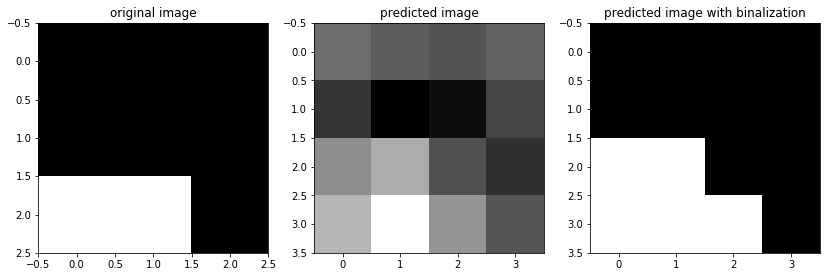

In [12]:
test_img = np.array([[1,1,1,1,1,1,0,0,1]])
autoencoder.predict(test_img)

In [7]:
q_given_p = df.where(df.iloc[:,:16] == autoencoder.preds_binary.reshape(16,), df.iloc[:,16:]).dropna().iloc[:,16:]


NameError: name 'df' is not defined

In [ ]:
test_img = np.array([[1,1,1,1,1,1,0,1,1]])
p_given_q = df.where(df.iloc[:, 16:] == test_img.reshape(9,), df.iloc[:,:16]).dropna().iloc[:, :16]


In [ ]:
p_given_q.head()

In [ ]:
_dict = {}
for i in range(p_given_q.shape[0]):
    _temp = p_given_q.iloc[i,:].values
    _temp = str(_temp)
    if _temp not in _dict.keys():
        _dict[_temp] = 1
    else:
        _dict[_temp] += 1

In [ ]:
sorted(_dict.items(), key=lambda x: x[1], reverse = True)

In [ ]:
_dict = {'1' : np.array([1,2]), '2' : 2}

In [ ]:
test = list(np.array([1,2]))
test

In [ ]:
df = pd.read_csv("../4x4matrix.csv", index_col=0)
df[df.iloc[:,16] <= 1] = 0
df[df >= 2] = 1
df.head(5)